In [1]:
import anndata as ad
import scanpy as sc

PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_single_cell__label_cell_type__processed.h5ad'

adata_predict = ad.read_h5ad(PATH)
nbins = adata_predict.uns['nbins']
results = adata_predict.uns['results']
# sc.tl.dendrogram(adata_predict, groupby="label", use_rep="X")

/opt/conda/envs/pytorch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  mean_df = rep_df.groupby(level=0).mean()


ValueError: Distance matrix 'X' must be symmetric.

In [2]:
adata_predict

AnnData object with n_obs × n_vars = 144885 × 5792
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'label', 'n_genes', 'train', 'marker_gene', 'marker_feature_name'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'column_1', 'column_2', 'column_3', 'column_4', 'external_gene_name', 'gene_biotype', 'train'
    uns: 'nbins', 'preprocessing', 'rank_genes_groups', 'results', 'var_embedding_pca'
    varm: 'embedding', 'embedding_pca'
    layers: 'confidence', 'measured', 'predicted'

In [3]:
print(
    f"""
    mean spearmanr across genes {results['spearmanr_across_genes_mean']:.3f}
    mean spearmanr across cells {results['spearmanr_across_cells_mean']:.3f}
    mean square error {results['mse']:.3f}
    ks-statistic on total expression {results['ks_statistic']:.3f}
    mean percent total expression captured per cell {results['total_expression_captured']:.3f}
    """
)

if nbins is not None:
    print(
        f"""
        accuracy {results['accuracy_score']:.3f}
        precision {results['precision']:.3f}
        recall {results['recall']:.3f}
        fscore {results['fscore']:.3f}
        """
    )  


    mean spearmanr across genes 0.224
    mean spearmanr across cells 0.102
    mean square error 14.169
    ks-statistic on total expression 0.107
    mean percent total expression captured per cell 50.792
    

        accuracy 0.873
        precision 0.211
        recall 0.102
        fscore 0.114
        


Global seed set to 0


ValueError: x and y must have same first dimension, but have shapes (1, 5792) and (5792,)

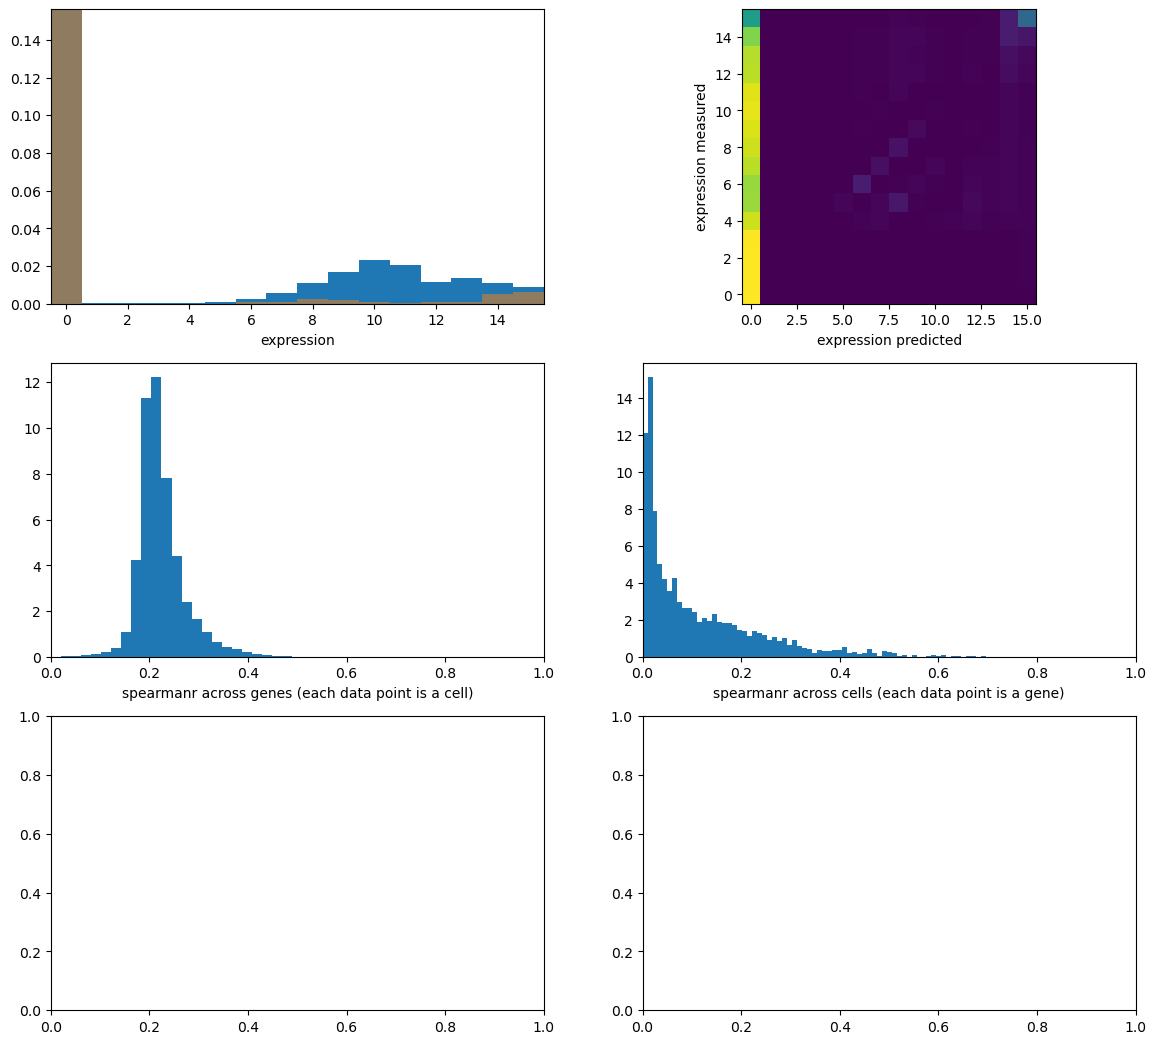

In [4]:
from rosa.utils import plot_expression_and_correlation, plot_marker_gene_heatmap

if nbins is not None:
    mev = nbins - 1
else:
    mev = 6
    
plot_expression_and_correlation(adata_predict, results, max_expression_val=mev, nbins=nbins)

In [ ]:
import numpy as np


marker_genes = adata_predict.var[adata_predict.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_predict, marker_genes, max_expression_val=mev)

         Falling back to preprocessing with `sc.pp.pca` and default params.


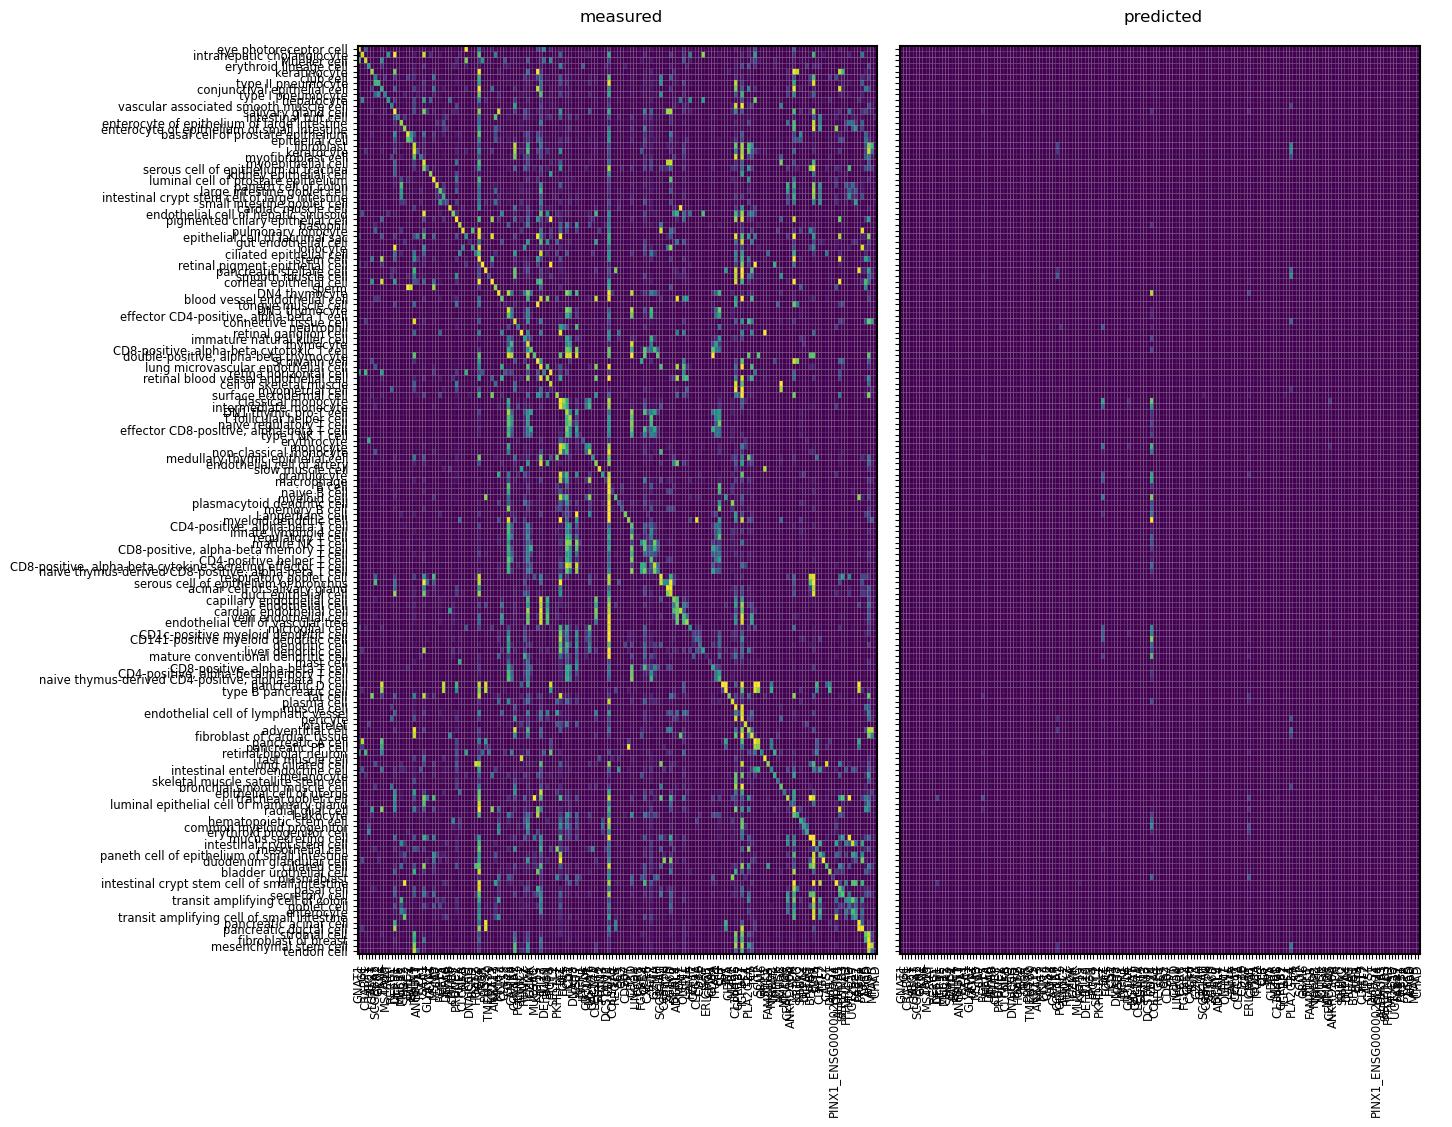

In [5]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_predict, marker_genes_dict, max_expression_val=mev)

In [ ]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage
import sys


sys.setrecursionlimit(100000)

In [ ]:
row_linkage = linkage(adata_predict.layers['measured']) # D being the measurement
col_linkage = linkage(adata_predict.layers['measured'].T) # D being the measurement
sns.clustermap(adata_predict.layers['measured'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
sns.clustermap(adata_predict.layers['predicted'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
sns.clustermap(adata_predict.layers['confidence'], row_linkage=row_linkage, col_linkage=col_linkage)